This is Original implementation of Unet paper.

In [40]:
import torch.nn as nn
import torch
import torch.nn.functional as F

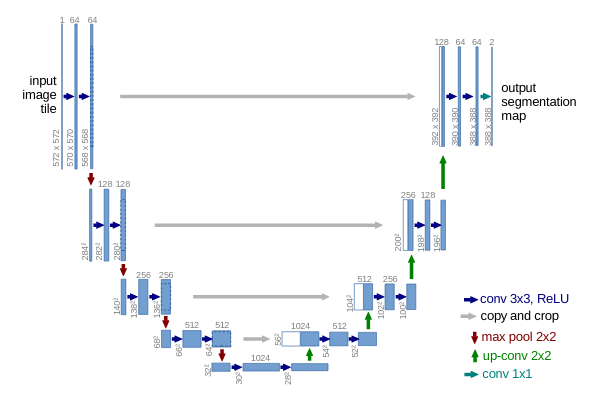

*  Two convoluion of 3x3 kernel size in encoder . Then a 2x2 Maxpooling with stride=2 is used.

* In decoder, Every  step  in  the  decoder  path  consists  of  an  upsampling  of  thefeature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels.Then this is concatenated with the correspondingly croppedfeature  map  from  the  contracting  path.

* Then this concatinated input us passed through two  3x3  convolutions,  each followed by a ReLU. 


In [41]:
def double_conv(in_ch,out_ch):
    conv =  nn.Sequential(
        nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=(3,3)),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=(3,3)),
        nn.ReLU(inplace=True)
    )
    return conv


def center_crop(small_image,large_image):
    small_h,small_w = small_image.shape[2],small_image.shape[3] # 200
    large_h,large_w = large_image.shape[2],large_image.shape[3] # 300
    delta_h = large_h - small_h  #100
    delta_w = large_w - small_w
    start_h,start_w = delta_h //2, delta_w//2 # 50
    cropped_images = large_image[:,:,start_h:large_h-start_h,start_w:large_w-start_w]
    return cropped_images

In [42]:

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.dconv1 = double_conv(in_ch=1,out_ch=64)
        self.dconv2 = double_conv(in_ch=64,out_ch=128)
        self.dconv3 = double_conv(in_ch=128,out_ch=256)
        self.dconv4 = double_conv(in_ch=256,out_ch=512)
        self.dconv5 = double_conv(in_ch=512,out_ch=1024)

        self.dconv1_up = double_conv(in_ch=1024,out_ch=512)
        self.dconv2_up = double_conv(in_ch=512,out_ch=256)
        self.dconv3_up = double_conv(in_ch=256,out_ch=128)
        self.dconv4_up = double_conv(in_ch=128,out_ch=64)

        self.upconv1 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
        self.upconv2 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.upconv3 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.upconv4 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)

        self.conv = nn.Conv2d(in_channels=64,out_channels=1,kernel_size=1)


    def forward(self,x):
        # encoder
        c1 = self.dconv1(x)
        d1 = self.maxpool(c1)
        c2 = self.dconv2(d1)
        d2 = self.maxpool(c2)
        c3 = self.dconv3(d2)
        d3 = self.maxpool(c3)
        c4 = self.dconv4(d3)
        d4 = self.maxpool(c4)
        c5 = self.dconv5(d4)
      
        # decoder
        up = self.upconv1(c5)  #1024->512
        c4_crop = center_crop(up,c4)
        up1 = self.dconv1_up(torch.cat([c4_crop,up],axis=1))  # 512+512->1024

        up = self.upconv2(up1)  
        c3_crop = center_crop(up,c3)
        up2 = self.dconv2_up(torch.cat([c3_crop,up],axis=1)) 

        up = self.upconv3(up2)  
        c2_crop = center_crop(up,c2)
        up3 = self.dconv3_up(torch.cat([c2_crop,up],axis=1)) 

        up = self.upconv4(up3)  
        c1_crop = center_crop(up,c1)
        up4 = self.dconv4_up(torch.cat([c1_crop,up],axis=1)) 
        
        out = self.conv(up4)
        return out


In [43]:
model = UNet()
model

UNet(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dconv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv5): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  

In [44]:
img = torch.randint(low=0,high=255,size=(1,1,572,572)).float()
img.shape

torch.Size([1, 1, 572, 572])

In [45]:
out = model(img)
out.shape

torch.Size([1, 1, 388, 388])